In [1]:
import numpy as np
import pandas as pd

from pprint import pprint

nprint = lambda l: print('\n'.join(list(l)))

In [2]:
from pathlib import Path

# benchmarks = { path.stem: pd.read_csv(path) for path in Path('data/').glob('*/csv/*.csv') }

# Remove un-wanted dataframes
# del benchmarks['cuda-mst-naive-K020-E1'] # Over-segmented
# del benchmarks['cuda-mst-naive-K040-E1'] # Over-segmented
# del benchmarks['gpu-baseline-S3']        # Broken segmentation
# del benchmarks['rec-mst-S2']             # Over-segmented
# del benchmarks['rec-mst-S3']             # Over-segmented
# del benchmarks['cpu-baseline-K040']      # Over-segmented
# del benchmarks['cpu-baseline-K640']      # Under-segmented

benchmarks = {
    '1-cpu-baseline': pd.read_csv("data/cpu-baseline/csv/cpu-baseline-K080.csv"),
    '2-gpu-baseline': pd.read_csv("data/gpu-baseline/csv/gpu-baseline-S4.csv"),
    '3-atomic-felz': pd.read_csv("data/cuda-mst-naive-new-fixed/csv/cuda-mst-naive-new-fixed-K080-E1.csv"),
    '4-dpp-segment-hier': pd.read_csv("data/amory-final/csv/amory-final.csv"),
    # '4-dpp-segment-hier': pd.read_csv("data/rec-mst/csv/rec-mst-S4.csv"),
    '5-dpp-superpix-hier': pd.read_csv("data/rec-mst-new-edge/csv/rec-mst-new-S4.csv"),
    '6-gu-dpp-segment-hier': pd.read_csv("data/aka-mst-nmg-fixed/csv/aka-mst-nmg-fixed-S3.csv"),
}

for name, df in benchmarks.items():    
    # Remove directories in output and ground_truth paths
    stemify = lambda p: Path(p).stem
    split1 = lambda p: stemify(p).split('_')[0]
    split2 = lambda p: stemify(p).split('_')[1]
    
    df['output'] = df['output'].apply(split1)
    df['ground_truth'] = df['ground_truth'].apply(split2)
    
    # Keep only the ground_truth that has the best ASA score for each output
    df = df[df.groupby(['output'])['asa_score'].transform(max) == df['asa_score']]
    
    benchmarks[name] = df

In [3]:
# List benchmark names
nprint(benchmarks.keys())

1-cpu-baseline
2-gpu-baseline
3-atomic-felz
4-dpp-segment-hier
5-dpp-superpix-hier
6-gu-dpp-segment-hier


In [4]:
print('ASA')
nprint([f"{name:<25} | {df['asa_score'].mean():.3f}" for name, df in benchmarks.items()])
print()

print('UE')
nprint([f"{name:<25} | {df['ue_score'].mean():.3f}" for name, df in benchmarks.items()])

ASA
1-cpu-baseline            | 0.971
2-gpu-baseline            | 0.938
3-atomic-felz             | 0.898
4-dpp-segment-hier        | 0.923
5-dpp-superpix-hier       | 0.923
6-gu-dpp-segment-hier     | 0.855

UE
1-cpu-baseline            | 0.057
2-gpu-baseline            | 0.124
3-atomic-felz             | 0.201
4-dpp-segment-hier        | 0.153
5-dpp-superpix-hier       | 0.152
6-gu-dpp-segment-hier     | 0.269


In [5]:
sorted_names = sorted(benchmarks.keys())

full_names = {
    '1-cpu-baseline': 'CPU Baseline',
    '2-gpu-baseline': 'GPU Baseline',
    '3-atomic-felz': 'Atomic Felzen.',
    '4-dpp-segment-hier': 'DPP Segment. Hier.',
    '6-gu-dpp-segment-hier': 'Ground-up DPP Segment. Hier.',
    '5-dpp-superpix-hier': 'DPP Superpix. Hier.'
}

palette = {
    '1-cpu-baseline': '#e41a1c',
    '2-gpu-baseline': '#377eb8',
    '3-atomic-felz': '#4daf4a',
    '4-dpp-segment-hier': '#a65628',
    '6-gu-dpp-segment-hier': '#f781bf',
    '5-dpp-superpix-hier': '#777777'
}

light_palette = {
    '1-cpu-baseline': '#FFA9AA',
    '2-gpu-baseline': '#B3D3EE',
    '3-atomic-felz': '#BBE7B9',
    '4-dpp-segment-hier': '#E7C2AD',
    '6-gu-dpp-segment-hier': '#FFCEEB',
    '5-dpp-superpix-hier': '#CFCFCF'
}

In [6]:
# Generate a mean score .csv for use as a table in LaTeX

import csv

with open('data/MeanScores.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['', *map(full_names.get, sorted_names)])
    writer.writerow(['ASA', *[benchmarks[name]['asa_score'].mean() for name in sorted_names]])
    writer.writerow(['UE', *[benchmarks[name]['ue_score'].mean() for name in sorted_names]])

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats; set_matplotlib_formats('svg')

In [8]:
font = {
    'size'   : 12,
}

mpl.rc('font', **font)

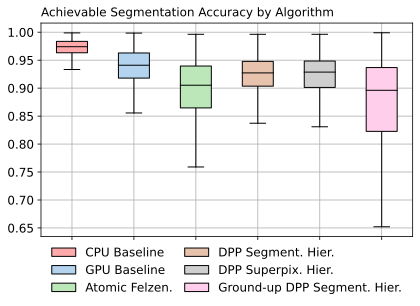

In [9]:
asa_data = [benchmarks[name]['asa_score'] for name in sorted_names]

fig, ax = plt.subplots(nrows=1, ncols=1)
bp = ax.boxplot(asa_data, patch_artist=True, showfliers=False)

for i in range(len(bp['boxes'])): 
    bp['boxes'][i].set_facecolor(light_palette[sorted_names[i]])
    bp['medians'][i].set_color('black')

ax.grid()
ax.legend(bp['boxes'],
          map(full_names.get, sorted_names),
          bbox_to_anchor=(0, -0.32, 1, 0),
          loc='lower left',
          mode='expand',
          ncol=2,
          frameon=False)

ax.set_xticklabels('')
# Title should be in LaTeX figure name
#ax.set_title('Achievable Segmentation Accuracy')

ax.set_ylabel("Achievable Segmentation Accuracy by Algorithm", rotation=0, horizontalalignment='left')
ax.yaxis.set_label_coords(0, 1.02)

fig.set_size_inches(6, 4.5)
fig.tight_layout()
fig.savefig('data/Plot_ASA.eps')
plt.show()

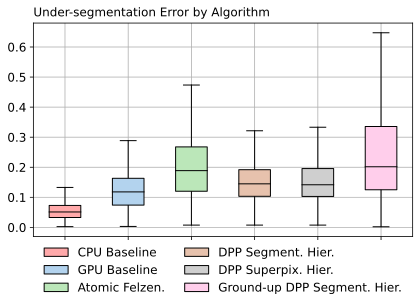

In [10]:
ue_data = [benchmarks[name]['ue_score'] for name in sorted_names]

fig, ax = plt.subplots(nrows=1, ncols=1)
bp = ax.boxplot(ue_data, patch_artist=True, showfliers=False)

for i in range(len(bp['boxes'])): 
    bp['boxes'][i].set_facecolor(light_palette[sorted_names[i]])
    bp['medians'][i].set_color('black')

ax.grid()
ax.legend(bp['boxes'],
          map(full_names.get, sorted_names),
          bbox_to_anchor=(0, -0.32, 1, 0),
          loc='lower left',
          mode='expand',
          ncol=2,
          frameon=False)

ax.set_xticklabels('')
# Title should be in LaTeX figure name
#ax.set_title('Achievable Segmentation Accuracy')

ax.set_ylabel("Under-segmentation Error by Algorithm", rotation=0, horizontalalignment='left')
ax.yaxis.set_label_coords(0, 1.02)

fig.set_size_inches(6, 4.5)
fig.tight_layout()
fig.savefig('data/Plot_UE.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


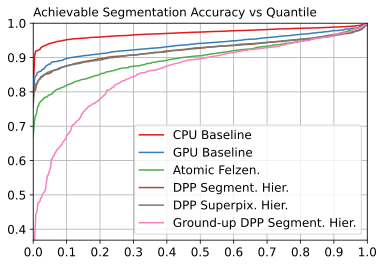

In [11]:
asa_cdf = np.array([sorted(benchmarks[name]['asa_score']) for name in sorted_names])

fig, ax = plt.subplots(nrows=1, ncols=1)

min_cdf = 1.0

for name, cdf in zip(sorted_names, asa_cdf):
#     if '6' in name:
#         continue
    
    ax.plot(np.linspace(0, 1, len(cdf)), cdf, label=full_names[name], color=palette[name])
    min_cdf = min(min_cdf, min(cdf))

fig.set_size_inches(6, 4.)

ax.set_xticks(np.arange(0., 1.1, 0.1))
ax.set_xlim(0, 1)

ax.set_ylim(min_cdf+0.1, 1)

ax.set_ylabel("Achievable Segmentation Accuracy vs Quantile", rotation=0, horizontalalignment='left')
ax.yaxis.set_label_coords(0, 1.02)

ax.grid()
ax.legend()
fig.savefig('data/Plot_ASAQuant.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


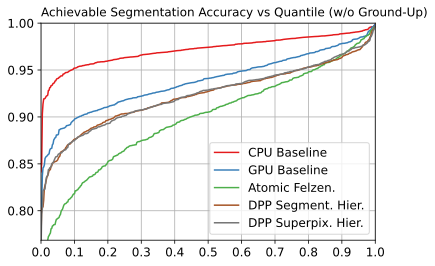

In [12]:
asa_cdf = np.array([sorted(benchmarks[name]['asa_score']) for name in sorted_names])

fig, ax = plt.subplots(nrows=1, ncols=1)

min_cdf = 1.0

for name, cdf in zip(sorted_names, asa_cdf):
    if '6' in name:
        continue
    
    ax.plot(np.linspace(0, 1, len(cdf)), cdf, label=full_names[name], color=palette[name])
    min_cdf = min(min_cdf, min(cdf))

fig.set_size_inches(6, 4.)

ax.set_xticks(np.arange(0., 1.1, 0.1))
ax.set_xlim(0, 1)

ax.set_ylim(min_cdf+0.1, 1)

ax.set_ylabel("Achievable Segmentation Accuracy vs Quantile (w/o Ground-Up)", rotation=0, horizontalalignment='left')
ax.yaxis.set_label_coords(0, 1.02)

ax.grid()
ax.legend()
fig.savefig('data/Plot_ASAQuant_NoGU.eps')
plt.show()

<ipython-input-13-af7340bc032c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(image_ids), rotation=90)


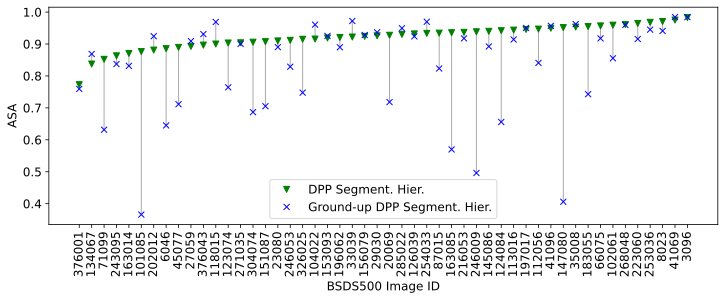

In [13]:
green_team = '4-dpp-segment-hier'
blue_team = '6-gu-dpp-segment-hier'

# Deepmind plot
baseline = benchmarks[green_team].sort_values('asa_score')
image_ids = baseline['output'][::10]

asa_cpu = benchmarks[green_team].set_index('output').loc[image_ids]['asa_score']
asa_gup = benchmarks[blue_team].set_index('output').loc[image_ids]['asa_score']

fig, ax = plt.subplots()
fig.set_size_inches((12, 4))

asa_min = pd.concat([asa_cpu, asa_gup], axis=1).min(axis=1)
asa_max = pd.concat([asa_cpu, asa_gup], axis=1).max(axis=1)

ax.vlines(image_ids, asa_min, asa_max, color='darkgrey', linewidth=1)

ax.plot(asa_cpu, 'v', color='green', label=full_names[green_team])
ax.plot(asa_gup, 'x', color='blue', label=full_names[blue_team])

ax.set_xticklabels(list(image_ids), rotation=90)

ax.legend()

ax.set_xlabel('BSDS500 Image ID')
ax.set_ylabel('ASA')

plt.show()